In [1]:
from salad.serialize import read
import astropy.table
import matplotlib.pyplot as plt
import numpy as np

In [2]:
fakes = read("../search/new_pipeline/fakes.pkl")

In [3]:
fakes['night'] = list(map(int, fakes['mjd_mid'] - 0.5))

In [4]:
num_nights = astropy.table.Table(
    list(
        map(
            lambda x : {
                "orbit": x[0]['ORBITID'], 
                "nights": len(x.group_by("night").groups)
            }, 
            fakes.group_by("ORBITID").groups
        )
    )
)

In [22]:
orbit > 1e6

True

In [33]:
multi_nights[multi_nights['orbit'] == orbit]

orbit,nights
int64,int64
10643454,6


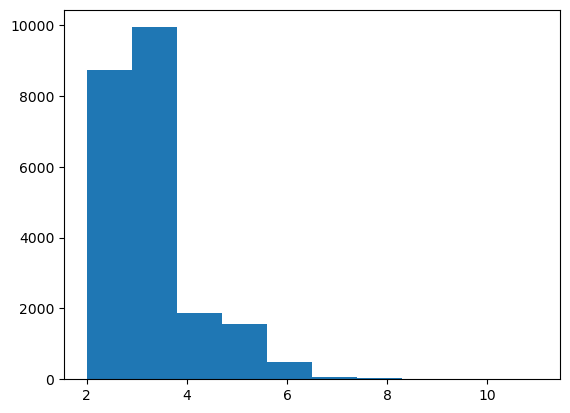

In [34]:
plt.hist(multi_nights['nights'])
plt.show()

In [23]:
multi_nights = num_nights[(num_nights['nights'] > 1)]

a = []
for g in fakes.group_by("night").groups:
    for orbit in set(g['ORBITID']):
        b = multi_nights[multi_nights['orbit'] == orbit]
        if len(b) > 0 and orbit > 1e6:
            a.append(
                {
                    "night": g[0]['night'],
                    "orbits": len(b)
                }
            )
        
#     if g[0]['night'] in multi_nights['nights']:
#         multi_nights.append(
#             {
#                 "night": g[0]['night'],
#                 "orbits": 
#             })
#         for orbit in num_nights[(num_nights['nights'] > 1)]['orbit']:
        
#     for night in fakes[fakes['ORBITID'] == orbit]['night']:
#         multi_nights.append(
#             {
#                 "night": night,
#                 "count": 1
#             }
#         )
a = astropy.table.Table(a)

In [30]:
len(set(fakes[fakes['night'] == 58575]['ORBITID']))

959

In [31]:
len(set(fakes[fakes['night'] == 58576]['ORBITID']))

958

In [25]:
list(
    map(
        lambda x : dict(
            night=x[0]['night'], 
            num_orbits=x['orbits'].sum(),
        ), 
        a.group_by("night").groups
    )
)

[{'night': 58575, 'num_orbits': 864},
 {'night': 58576, 'num_orbits': 863},
 {'night': 58607, 'num_orbits': 1735},
 {'night': 58608, 'num_orbits': 1838},
 {'night': 58610, 'num_orbits': 1596},
 {'night': 58635, 'num_orbits': 726},
 {'night': 58636, 'num_orbits': 608},
 {'night': 58637, 'num_orbits': 1012},
 {'night': 58670, 'num_orbits': 816},
 {'night': 58671, 'num_orbits': 897},
 {'night': 58672, 'num_orbits': 860},
 {'night': 58722, 'num_orbits': 1734},
 {'night': 58723, 'num_orbits': 1883},
 {'night': 58724, 'num_orbits': 1757},
 {'night': 58752, 'num_orbits': 770},
 {'night': 58753, 'num_orbits': 825},
 {'night': 58754, 'num_orbits': 759},
 {'night': 59137, 'num_orbits': 894},
 {'night': 59138, 'num_orbits': 1439},
 {'night': 59139, 'num_orbits': 1477},
 {'night': 59140, 'num_orbits': 1549},
 {'night': 59141, 'num_orbits': 1011},
 {'night': 59142, 'num_orbits': 844},
 {'night': 59143, 'num_orbits': 970},
 {'night': 59337, 'num_orbits': 751},
 {'night': 59338, 'num_orbits': 291},
 

In [ ]:
multi_nights = astropy.table.Table(multi_nights)

In [ ]:
multi_nights

In [ ]:
mags = []
for g in fakes.group_by("ORBITID").groups:
    mags.append(
        {
            "orbit": g[0]['ORBITID'],
            "mag": np.median(g['MAG'])
        }
    )
mags = astropy.table.Table(mags)

In [ ]:
def was_found(fake_recovery):
    ret = {}
    for o in fake_recovery:
        f = fake_recovery[o]
        found = False
        for c in f['points']:
            p = f['points'][c]
            precision = p['fake']/p['total']
            recall = p['fake']/f['catalog']['fake']
            if c in f['line']:
                l = f['line'][c]
                line_recovery = l['fake']/l['total']
                if precision > 0.5 and line_recovery > 0.5:
                    found = True
        ret[o] = found
    return ret
            
r = read(
    "../search/new_pipeline/DEEP/20190403/A0c/detector_1/snr_5.0/shuffled/single_search/recovered_filter.pkl"
)
was_found(r)

In [15]:
from pathlib import Path

In [27]:
Path("../search/new_pipeline/DEEP/20190403/A0c/detector_1/snr_5.0/shuffled/single_search/recovered_filter.pkl")

PosixPath('../search/new_pipeline/DEEP/20190403/A0c/detector_1/snr_5.0/shuffled/single_search')

In [37]:
paths = list(Path("../search/single_search/DEEP/20190403/A0c").rglob("recovered_*.pkl"))

In [116]:
data = []
for path in paths:
    step = path.name.split("recovered_")[1].replace(".pkl", "")
    p = path.parent.parent
    t = p.name
    p = p.parent
    snr = float(p.name.split("_")[1])
    p = p.parent
    detector = int(p.name.split("_")[1])
    p = p.parent
    target = p.name
    p = p.parent
    night = int(p.name)
    d = read(str(path))
    found = was_found(d)
    for k in found:
        findable = None
        if 'findable' in d[k]['info']:
            findable = d[k]['info']['findable']
        data.append(
            {
                "type": t,
                "snr": snr,
                "detector": detector,
                "target": target,
                "night": night,
                "orbit": k,
                "found": found[k],
                "findable": findable,
                "step": step,
            }
        )

        
data = astropy.table.Table(data)

In [117]:
data = astropy.table.join(data, mags, keys=['orbit'])

In [167]:
for o in np.unique(data[data['findable'] == True]['orbit']):
    data['findable'][data['orbit'] == o] = True
data['findable'][data['findable'] == None] = False

In [110]:
data[(data['snr'] == 3.0) & (data['type'] == 'unshuffled') & (data['step'] == 'clusters')]

type,snr,detector,target,night,orbit,found,step,mag
str10,float64,int64,str3,int64,int64,bool,str23,float64
unshuffled,3.0,1,A0c,20190403,10041343,False,clusters,22.428969812125573
unshuffled,3.0,1,A0c,20190403,10053463,False,clusters,25.510624016190786
unshuffled,3.0,26,A0c,20190403,10114448,False,clusters,25.689471030290612
unshuffled,3.0,31,A0c,20190403,10155244,False,clusters,20.265084937985776
unshuffled,3.0,62,A0c,20190403,10200778,False,clusters,22.692741713279823
unshuffled,3.0,27,A0c,20190403,10205130,False,clusters,24.920896138136044
unshuffled,3.0,34,A0c,20190403,10228593,False,clusters,24.683906721161264
unshuffled,3.0,29,A0c,20190403,10275777,False,clusters,23.81079372234848
unshuffled,3.0,5,A0c,20190403,10451789,False,clusters,23.754526736593633


3.0
3.5
4.0
4.5
5.0


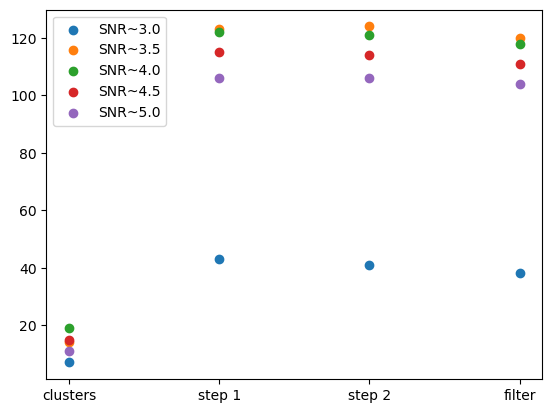

In [78]:
for g1 in data.group_by(["snr", "target", "night", "type"]).groups:
    if g1[0]['type'] == "shuffled":
        continue
    y = {}
    for g2 in g1.group_by(["step"]).groups:
        y[g2[0]['step']] = g2['found'].sum()
    
#     print(g1[0]['snr'])
    plt.scatter([0, 1, 2, 3], [y['clusters'], y['1'], y['2'], y['filter']], label=f"SNR~{g1[0]['snr']}")
    
plt.xticks([0, 1, 2, 3], ['clusters', 'step 1', 'step 2', 'filter'])
plt.legend()
plt.show()

/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


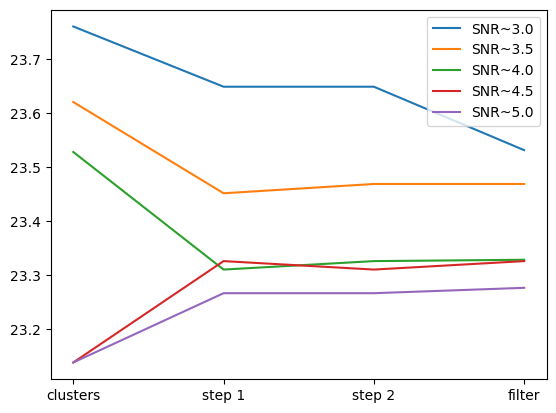

In [135]:
for g1 in data.group_by(["snr", "target", "night", "type"]).groups:
    if g1[0]['type'] == "shuffled":
        continue
    y = {}
    for g2 in g1.group_by(["step"]).groups:
        y[g2[0]['step']] = np.median(g2[g2['found']]['mag'])
    
    plt.plot(
        [0, 1, 2, 3], 
        [y['clusters'], y['1'], y['2'], y['filter']], 
        label=f"SNR~{g1[0]['snr']}"
    )
    
plt.xticks(
    [0, 1, 2, 3], 
    ['clusters', 'step 1', 'step 2', 'filter']
)
plt.legend()
plt.show()

In [329]:
def bin_detection(catalog, min_mag, max_mag, dm=0.5, min_visits=10):
    fraction_recovered = []
    i = 0
    m = min_mag
    mag = []
    lower = min_mag
    errors = []
    while lower < max_mag:
        lower = min_mag + i * dm
        upper = min_mag + (i + 1) * dm
        a = catalog[(catalog['mag'] >= lower) & (catalog['mag'] < upper)]
        if len(a) > 0:
            num_recovered = a['found'].sum()
            num_possible = len(a)#a['catalog_possible'].sum()
            
            fraction_recovered.append(num_recovered/num_possible)
            mag.append((upper + lower) / 2)
            # num_recovered / num_total
            # sqrt(dx^2 + dy^2)
            errors.append((num_recovered**0.5)/num_possible)
#             errors.append((num_recovered + num_possible)**-0.5) # sqrt(dr**2 + da**2) where dr=sqrt(r)

        i += 1

    return mag, fraction_recovered, errors

from scipy.optimize import minimize, curve_fit
import numpy as np
from autograd import elementwise_grad as egrad
from autograd import jacobian, hessian
import autograd.numpy as np

def p(m, c, k, m_50):
    return c / (1 + np.exp(k * (m - m_50)))

def log_p(m, c, k, m_50):
    return np.log(c) - np.log(1 + np.exp(k * (m - m_50)))

def p_3(m, c, k1, k2, m_25):
    return p(m, c, k1, m_25) * p(m, 1, k2, m_25)

def log_p_3(m, c, k1, k2, m_25):
    return log_p(m, c, k1, m_25) + log_p(m, 1, k2, m_25)

def log_l(c, k, m_50, recovered_mag, missed_mag):
    if c > 1 or c < 0:
        return -np.inf
    return np.sum(log_p(recovered_mag, c, k, m_50)) + np.sum(np.log(1 - p(missed_mag, c, k, m_50)))


def log_l_3(c, k1, k2, m_25, recovered_mag, missed_mag):
    if c > 1 or c < 0:
        return -np.inf
    return (
        np.sum(np.log(p_3(recovered_mag, c, k1, k2, m_25))) + 
        np.sum(np.log(1 - p_3(missed_mag, c, k1, k2, m_25)))
    )

def fit_completeness(recovered_mag, missed_mag, eq=1, **kwargs):
    minimize_kwargs = dict(
        method="Nelder-Mead", 
        options=dict(maxiter=int(1e3))        
    )
    minimize_kwargs.update(kwargs)
    if eq == 1:
        log_likelihood = log_l
        init_x = np.array(minimize_kwargs.pop("init_x", [0.8, 1, 24]))
    else:
        log_likelihood = log_l_3
        init_x = np.array(minimize_kwargs.pop("init_x", [0.8, 1, 1, 24]))
    
    f = lambda x : -log_likelihood(*x, recovered_mag, missed_mag)
    df = egrad(f)
    jac = jacobian(f)
    hess = hessian(f)
    
    if minimize_kwargs['method'] != "Nelder-Mead":
        minimize_kwargs['jac'] = jac
        minimize_kwargs['hess'] = hess
    opt_result = minimize(f, init_x, **minimize_kwargs)
        
    return opt_result, hess(opt_result.x)


def do_fit(results):
    recovered_mag = results[results['found']]['mag'].value
    missed_mag = results[~results['found']]['mag'].value

    opt_result, hess = fit_completeness(recovered_mag, missed_mag, eq=1)

    d = None
    if opt_result.success:
        best_fit = opt_result.x
        if hess is not None:
            fit_std = np.sqrt(np.diag(np.linalg.inv(hess)))
        else:
            fit_std = np.array([np.nan, np.nan, np.nan])
        d = {
            "c": best_fit[0],
            "k": best_fit[1],
            "m_50": best_fit[2],
            "sigma_c": fit_std[0],
            "sigma_k": fit_std[1],
            "sigma_m_50": fit_std[2],
        }

    return d


In [151]:
fit_results = []
for g1 in data.group_by(["snr", "target", "night", "type"]).groups:
    if g1[0]['type'] == "shuffled":
        continue
    for g2 in g1.group_by(["step"]).groups:
        if "removed" in g2[0]['step']:
            continue
        d = do_fit(g2[g2['findable'] == True])
        fit_results.append(
            {
                "snr": g1[0]['snr'],
                "target": g1[0]['target'],
                "night": g1[0]['night'],
                "step": g2[0]['step'],
                "m_50": d['m_50'],
                "sigma_m_50": d['sigma_m_50'],
            }
        )
fit_results = astropy.table.Table(fit_results)
#         y[g2[0]['step']] = d['m_50']
#         yerr[g2[0]['step']] = d['sigma_m_50']
# #         plt.scatter(g2[g2['findable'] == True]['mag'], g2[g2['findable'] == True]['found'])
# #         plt.show()
    
#     plt.errorbar(
#         [0, 1, 2, 3], 
#         [y['clusters'], y['1'], y['2'], y['filter']], 
#         yerr=[yerr['clusters'], yerr['1'], yerr['2'], yerr['filter']],
#         label=f"SNR~{g1[0]['snr']}"
#     )
    
# plt.xticks(
#     [0, 1, 2, 3], 
#     ['clusters', 'step 1', 'step 2', 'filter']
# )
# plt.legend()
# plt.show()

/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in power
  return f_raw(*args, **kwargs)
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: overflow encountered in square
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:35: RuntimeWarning: invalid value encountered in multiply
  lambda ans, 

In [177]:
np.unique(data[
    (data['type'] == "unshuffled") & 
    (data['step'] == "filter") & 
    (data['found'] == False) & 
    (data['findable'] == True) &
    (data['mag'] < 23)
]['orbit'])

10129264
10155244
10406836
10464147
10580828
10976743
11074514
11117214
11460000
11478349
11526494


In [180]:
data[data['orbit'] == 10129264]

type,snr,detector,target,night,orbit,found,findable,step,mag
str10,float64,int64,str3,int64,int64,bool,object,str23,float64
shuffled,4.0,23,A0c,20190403,10129264,False,True,2_removed,22.674950978591525
shuffled,4.0,23,A0c,20190403,10129264,False,True,filter,22.674950978591525
shuffled,3.5,23,A0c,20190403,10129264,False,True,filter_removed_velocity,22.674950978591525
shuffled,4.0,23,A0c,20190403,10129264,False,True,filter_removed_velocity,22.674950978591525
shuffled,3.5,23,A0c,20190403,10129264,False,True,filter,22.674950978591525
shuffled,4.0,23,A0c,20190403,10129264,False,True,filter_removed_points,22.674950978591525
shuffled,3.5,23,A0c,20190403,10129264,False,True,2_removed,22.674950978591525
shuffled,3.5,23,A0c,20190403,10129264,False,True,clusters,22.674950978591525
shuffled,3.5,23,A0c,20190403,10129264,False,True,2,22.674950978591525


In [232]:
data[data['orbit'] == 10155244]

type,snr,detector,target,night,orbit,found,findable,step,mag
str10,float64,int64,str3,int64,int64,bool,object,str23,float64
unshuffled,3.5,31,A0c,20190403,10155244,False,True,filter_removed_points,20.265084937985776
unshuffled,5.0,31,A0c,20190403,10155244,False,True,2_removed,20.265084937985776
unshuffled,5.0,31,A0c,20190403,10155244,False,True,1,20.265084937985776
unshuffled,5.0,31,A0c,20190403,10155244,False,True,filter,20.265084937985776
unshuffled,5.0,31,A0c,20190403,10155244,False,True,2,20.265084937985776
unshuffled,5.0,31,A0c,20190403,10155244,False,True,1_removed,20.265084937985776
unshuffled,5.0,31,A0c,20190403,10155244,False,True,clusters,20.265084937985776
shuffled,3.0,31,A0c,20190403,10155244,False,True,filter_removed_velocity,20.265084937985776
unshuffled,5.0,31,A0c,20190403,10155244,False,True,filter_removed_points,20.265084937985776


In [188]:

read(
    "../search/single_search/DEEP/20190403/A0c/detector_23/snr_5.0/unshuffled/single_search/recovered_filter.pkl"
)[10129264]


{'points': {1: {'fake': 103, 'total': 103}},
 'line': {},
 'catalog': {'fake': 103, 'total': 104},
 'info': {'vra': <Quantity -0.18297329 deg / d>,
  'vdec': <Quantity 0.20185841 deg / d>}}

In [297]:
def found_points(recovery):
    data = []
    for o in recovery:
        cluster = None
        purity = 0
        for i, c in enumerate(recovery[o]['points']):
#             p = recovery[o]['points'][c]['fake'] / recovery[o]['points'][c]['total']
#             if p > purity:
#                 purity = p
#                 cluster = c
#         if cluster:
            data.append(
                {
                    "orbit": o,
                    "detections": recovery[o]['points'][c]['fake'],
                    "total": recovery[o]['points'][c]['total'],
                }
            )
            
    return data

In [318]:
data = []
for path in Path("../search/single_search/DEEP/20190403/A0c").rglob("recovered_2.pkl"):
    step = path.name.split("recovered_")[1].replace(".pkl", "")
    p = path.parent.parent
    t = p.name
    p = p.parent
    snr = float(p.name.split("_")[1])
    p = p.parent
    detector = int(p.name.split("_")[1])
    p = p.parent
    target = p.name
    p = p.parent
    night = int(p.name)
    d = read(str(path))
    found = found_points(d)
    for x in found:
        x['snr'] = snr
        x['detector'] = detector
        x['type'] = t
    data.extend(found)
data = astropy.table.Table(data)

In [319]:
data = astropy.table.join(data, mags)
data['purity'] = data['detections']/data['total']

In [321]:
data

orbit,detections,total,snr,detector,type,mag,purity
int64,int64,int64,float64,int64,str10,float64,float64
10002376,25,25,5.0,59,unshuffled,24.054322260817777,1.0
10002376,44,44,4.5,59,unshuffled,24.054322260817777,1.0
10002376,84,84,3.5,59,unshuffled,24.054322260817777,1.0
10002376,1,2,3.5,59,unshuffled,24.054322260817777,0.5
10002376,59,59,4.0,59,unshuffled,24.054322260817777,1.0
10041343,1,28,3.0,1,unshuffled,22.428969812125573,0.03571428571428571
10041343,1,40,3.5,1,unshuffled,22.428969812125573,0.025
10041343,18,18,3.0,1,unshuffled,22.428969812125573,1.0
10041343,5,6,3.0,1,unshuffled,22.428969812125573,0.8333333333333334


In [368]:
t

found,mag
bool,float64
False,22.428969812125573
False,22.428969812125573
False,22.428969812125573
False,22.428969812125573
False,25.510624016190786
True,22.692741713279823
False,22.692741713279823
True,23.81079372234848
True,23.81079372234848


In [369]:
data['mag']

24.054322260817777
24.054322260817777
24.054322260817777
24.054322260817777
24.054322260817777
22.428969812125573
22.428969812125573
22.428969812125573
22.428969812125573
22.428969812125573
22.428969812125573


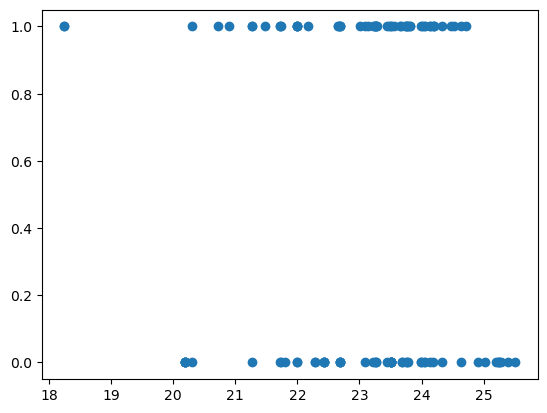

In [367]:
g1 = data[(data['type'] == 'unshuffled') & (data['snr'] == 3.0)]
t = astropy.table.Table(
    data=[[False] * len(g1), g1['mag']],
    names=['found', 'mag']
)
mask = (g1['purity'] > 0.5) & (g1['total'] >= 25)
t['found'][mask] = True
plt.scatter(t['mag'], t['found'])

In [371]:
do_fit(t)

/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: overflow encountered in square
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))


{'c': 0.5514018679525241,
 'k': 375.3160355241512,
 'm_50': 24.799727861861733,
 'sigma_c': 0.04808071952116546,
 'sigma_k': 842609704.6764723,
 'sigma_m_50': 200050.96299281548}

In [351]:
fit_results = []
for g1 in data.group_by(["type", "snr"]).groups:
    if g1[0]['type'] == "shuffled":
        continue
    for n in range(25):
        t = astropy.table.Table(
            data=[[False] * len(g1), g1['mag']],
            names=['found', 'mag']
        )
        mask = (g1['purity'] > 0.5) & (g1['total'] >= n)
        t['found'][mask] = True
        
        d = do_fit(t)
        fit_results.append(
            {
                "snr": g1[0]['snr'],
                "type": g1[0]['type'],
                "m_50": d['m_50'],
                "sigma_m_50": d['sigma_m_50'],
                "n": n,
            }
        )
fit_results = astropy.table.Table(fit_results)

/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: overflow encountered in square
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: overflow encountered in square
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: overfl

/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:35: RuntimeWarning: invalid value encountered in multiply
  lambda ans, x, y : unbroadcast_f(y, lambda g: x * g))
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:52: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.true_divide, lambda ans, x, y : unbroadcast_f(x, lambda g: g / y),
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:53: Runtim

/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in power
  return f_raw(*args, **kwargs)
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: overflow encountered in square
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:35: RuntimeWarning: invalid value encountered in multiply
  lambda ans, x, y : unbroadcast_f(y, lambda g: x * g))
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:52: RuntimeWarning: invalid 

/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in power
  return f_raw(*args, **kwargs)
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: overflow encountered in square
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:35: RuntimeWarning: invalid value encountered in multiply
  lambda ans, x, y : unbroadcast_f(y, lambda g: x * g))
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:52: RuntimeWarning: invalid 

/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:35: RuntimeWarning: invalid value encountered in multiply
  lambda ans, x, y : unbroadcast_f(y, lambda g: x * g))
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:52: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.true_divide, lambda ans, x, y : unbroadcast_f(x, lambda g: g / y),
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: invalid value encountered in divide
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-package

/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in power
  return f_raw(*args, **kwargs)
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: overflow encountered in square
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:35: RuntimeWarning: invalid value encountered in multiply
  lambda ans, 

In [378]:
fit_results[fit_results['snr'] == 3.0]

snr,type,m_50,sigma_m_50,n
float64,str10,float64,float64,int64
3.0,unshuffled,25.466523998838788,0.23744340306503614,0
3.0,unshuffled,25.466523998838788,0.23744340306503614,1
3.0,unshuffled,25.466523998838788,0.23744340306503614,2
3.0,unshuffled,25.466523998838788,0.23744340306503614,3
3.0,unshuffled,25.470335382833653,0.22607705977589163,4
3.0,unshuffled,84.55600871086642,78603079.00465819,5
3.0,unshuffled,25.446540656873616,83871.14557209142,6
3.0,unshuffled,49.660771479888446,nan,7
3.0,unshuffled,49.660771479888446,nan,8


[15,
 15,
 15,
 13,
 10,
 8,
 3,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

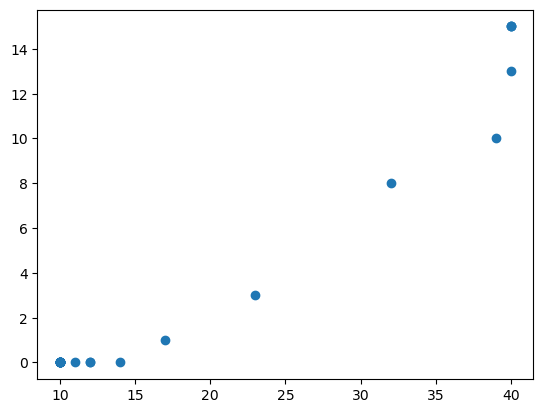

In [384]:
plt.scatter(snr_5['threshold']['x'], snr_5['threshold']['y'])
plt.show()

In [387]:
len(snr_5['threshold']['y'])

25

In [396]:
snr_3 = number_of_results(3.0, 5)

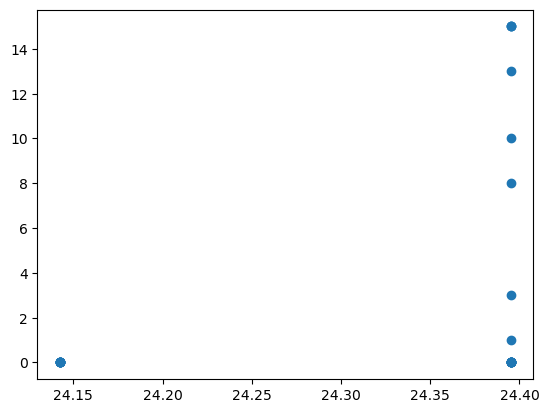

In [390]:
plt.scatter(
    fit_results[(fit_results['type'] == 'unshuffled') & (fit_results['snr'] == 3.0)]['m_50'], 
    snr_3['threshold']['y']
)
plt.show()

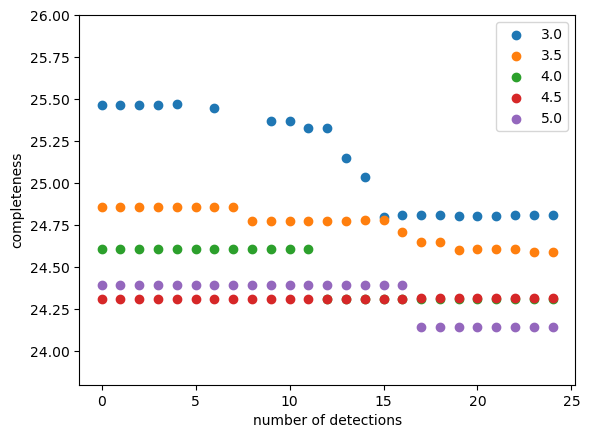

In [398]:
recover_results = []
for g1 in fit_results.group_by("type").groups:
    for g2 in fit_results.group_by("snr").groups:
#         mask = g2['sigma_m_50'] < 2
#         print(g2)
        plt.scatter(g2['n'], g2['m_50'], label=g2[0]['snr'])
plt.legend()
plt.ylim(23.8, 26)
plt.xlabel("number of detections")
plt.ylabel("completeness")
plt.show()

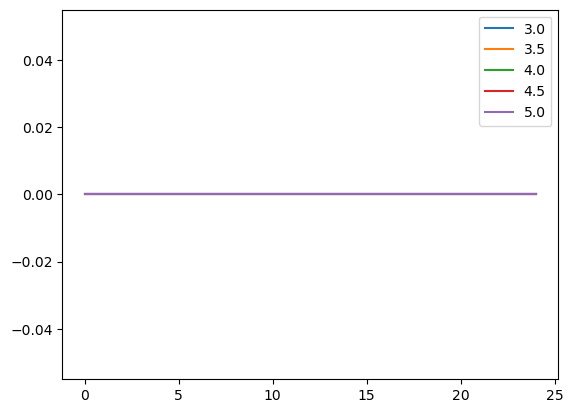

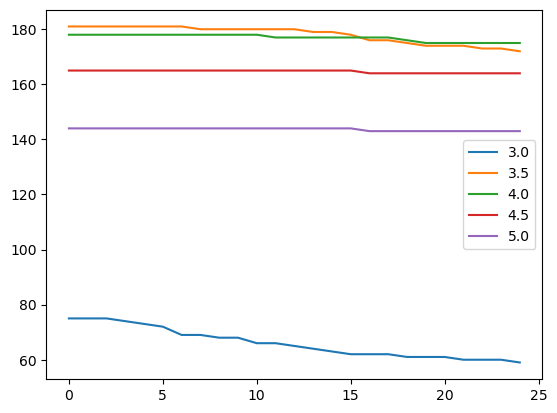

In [335]:
for g1 in data.group_by(["type"]).groups:
    for g2 in g1.group_by(["snr"]).groups:
        x = np.arange(25)
        y_num = []        
        y_mag = []
        y_mag_err = []
        mask = g2['purity'] > 0.5
        for i in x:
            
            y_num.append((g2[mask]['total'] > i).sum())
            
        plt.plot(x, y_num, label=g2[0]['snr'])
    plt.legend()
    plt.show()

In [291]:
# gather recovered_2 across all detectors / snr
# and just for each orbit check if it was found or not and how many detections that cluster had
# then you can threshold based on number of detections...
# I am looking for those fakes who might have been in a cluster with 10 detections
# let's say found means that it was matched to the cluster points and the cluster is >50% pure
# this is a proxy for we can estimate the line from this
read(
    "../search/single_search/DEEP/20190403/A0c/detector_23/snr_5.0/unshuffled/single_search/recovered_2.pkl"
)

{14924205: {'points': {},
  'line': {},
  'catalog': {'fake': 0, 'total': 10},
  'info': {'vra': <Quantity -0.18941998 deg / d>,
   'vdec': <Quantity 0.27249718 deg / d>}},
 10129264: {'points': {1: {'fake': 103, 'total': 103}},
  'line': {},
  'catalog': {'fake': 103, 'total': 104},
  'info': {'vra': <Quantity -0.18297329 deg / d>,
   'vdec': <Quantity 0.20185841 deg / d>}},
 10887476: {'points': {},
  'line': {},
  'catalog': {'fake': 46, 'total': 52},
  'info': {'vra': <Quantity -0.3403927 deg / d>,
   'vdec': <Quantity -0.11083155 deg / d>}},
 11416504: {'points': {},
  'line': {},
  'catalog': {'fake': 0, 'total': 104},
  'info': {'vra': <Quantity -0.13417018 deg / d>,
   'vdec': <Quantity 0.09865366 deg / d>}},
 10311420: {'points': {},
  'line': {},
  'catalog': {'fake': 27, 'total': 104},
  'info': {'vra': <Quantity -0.24965617 deg / d>,
   'vdec': <Quantity -0.04406615 deg / d>}}}

In [233]:

read(
    "../search/single_search/DEEP/20190403/A0c/detector_31/snr_5.0/unshuffled/single_search/recovered_filter.pkl"
)[10155244]


{'points': {},
 'line': {},
 'catalog': {'fake': 0, 'total': 104},
 'info': {'vra': <Quantity -0.12971143 deg / d>,
  'vdec': <Quantity -0.00046419 deg / d>}}

In [192]:
catalog = read(
    "../search/single_search/DEEP/20190403/A0c/detector_23/snr_5.0/catalog.pkl"
)
clusters = read(
    "../search/single_search/DEEP/20190403/A0c/detector_23/snr_5.0/unshuffled/single_search/filtered.pkl"
)
f = read(
    "../search/single_search/DEEP/20190403/A0c/detector_23/fakes.pkl"
)

c[0]

In [204]:
from salad.fakes.recover import recover
import astropy.units as u
from astropy.coordinates import SkyCoord

In [245]:
cluster = c[1]

line_locations = cluster.line.predict(f['mjd_mid'] * u.day)

c_line = SkyCoord(line_locations[:, 0], line_locations[:, 1])

t_line = astropy.table.Table(
    data=[[1]*len(c_line), c_line.ra, c_line.dec, f['EXPNUM'], f['ORBITID']],
    names=['cluster', 'ra', 'dec', 'expnum', 'orbit']
)

c_fake = SkyCoord(f['RA']*u.deg, f['DEC']*u.deg)

t1 = astropy.table.Table(
    data=[c_fake.ra, c_fake.dec, f['ORBITID'], f['EXPNUM']], 
    names=['ra', 'dec', 'orbit', 'expnum']
)

for g in astropy.table.join(t1, t_line, keys=['expnum', 'orbit']).group_by(["orbit", "cluster"]).groups:
    sep = SkyCoord(g['ra_1'], g['dec_1']).separation(SkyCoord(g['ra_2'], g['dec_2']))
    n_matches = (sep.value < 1.5/3600).sum()
    print(g[0]['orbit'], g[0]['cluster'], n_matches, np.median(sep.value)*3600)

10129264 1 104 1.1096254234444625
10311420 1 0 338.94705909662775
10887476 1 0 668.5342755339163
11416504 1 0 602.4546300383895
14924205 1 0 578.1189035958467


In [289]:
sum(list(was_found(recover(f, c, catalog, match_threshold_line=1.5/3600)).values()))

1

In [259]:
# what I want to know is:
# I have a knob: 
# - number of detections within X arcseconds

# How do I test this?
# Get the step2 results filtered on velocity for shuffled/unshuffled and filter on n
# changing n
# recover the fakes for each n and measure completeness


paths = Path("../search/single_search/DEEP/20190403/A0c").rglob("step2.pkl")
paths = list(filter(lambda x : all([n in str(x) for n in ['snr_5.0']]), paths))

In [262]:
step2 = read(str(paths[0]))

In [267]:
from functools import partial

list(filter(partial(filter_velocity, vmin=0.1, vmax=0.5), step2))

25

In [284]:
from salad.cluster.filter import filter_velocity, filter_n

def number_of_results(snr, detector):
    fakes = read(f"../search/single_search/DEEP/20190403/A0c/detector_{detector}/fakes.pkl") 
    catalog = read(f"../search/single_search/DEEP/20190403/A0c/detector_{detector}/snr_{snr}/catalog.pkl")     
    catalog_shuffled = read(f"../search/single_search/DEEP/20190403/A0c/detector_{detector}/snr_{snr}/catalog_shuffled.pkl") 
    args = read(f"../search/single_search/DEEP/20190403/A0c/detector_{detector}/snr_{snr}/unshuffled/single_search/_vars.pkl")
    clusters = read(f"../search/single_search/DEEP/20190403/A0c/detector_{detector}/snr_{snr}/unshuffled/single_search/clusters.pkl")
    step1 = read(f"../search/single_search/DEEP/20190403/A0c/detector_{detector}/snr_{snr}/unshuffled/single_search/step1.pkl")
    step2 = read(f"../search/single_search/DEEP/20190403/A0c/detector_{detector}/snr_{snr}/unshuffled/single_search/step2.pkl")
    clusters_shuffled = read(f"../search/single_search/DEEP/20190403/A0c/detector_{detector}/snr_{snr}/shuffled/single_search/clusters.pkl")
    step1_shuffled = read(f"../search/single_search/DEEP/20190403/A0c/detector_{detector}/snr_{snr}/shuffled/single_search/step1.pkl")
    step2_shuffled = read(f"../search/single_search/DEEP/20190403/A0c/detector_{detector}/snr_{snr}/shuffled/single_search/step2.pkl")
    
    search_filter_velocity = list(filter(
        lambda x : filter_velocity(x, vmin=min(args['velocity']), vmax=max(args['velocity'])), 
        step2,
    ))
    search_filter_n = list(filter(
        lambda x : filter_n(x, n=args['min_points']), 
        search_filter_velocity
    ))
    search_shuffled_filter_velocity = list(filter(
        lambda x : filter_velocity(x, vmin=min(args['velocity']), vmax=max(args['velocity'])), 
        step2_shuffled
    ))
    
    search_shuffled_filter_n = list(filter(
        lambda x : filter_n(x, n=15), 
        search_shuffled_filter_velocity
    ))    
    
    result = {}
    x = np.arange(5)
    y = [
        len(clusters), 
        len(step1), 
        len(step2), 
        len(search_filter_velocity), 
        len(search_filter_n)
    ]
    y_s = [
        len(clusters_shuffled), 
        len(step1_shuffled), 
        len(step2_shuffled), 
        len(search_shuffled_filter_velocity), 
        len(search_shuffled_filter_n)
    ]
    
    result['num_results'] = {
        "x": x,
        "y": y,
        "y_s": y_s
    }

    t = list(range(25))
    x = []
    x_fake = []
    y = []
    y_fake = []
    for n in t:
        search_filter_n = list(filter(
            lambda x : filter_n(x, n=n), 
            search_filter_velocity
        ))
        n_results = len(search_filter_n)
        x_fake.append(sum(list(was_found(recover(fakes, search_filter_n, catalog)).values())))
        x.append(n_results)
        search_filter_n = list(filter(
            lambda x : filter_n(x, n=n), 
            search_shuffled_filter_velocity
        ))
        y_fake.append(sum(list(was_found(recover(fakes, search_filter_n, catalog_shuffled)).values())))
        n_results = len(search_filter_n)
        y.append(n_results)
    
    result['threshold'] = {
        "t": t,
        "x": x,
        "y": y,
        "x_fake": x_fake,
        "y_fake": y_fake,
    }
    return result
    

In [285]:
snr_5 = number_of_results(5.0, 16)

In [286]:
snr_5

{'num_results': {'x': array([0, 1, 2, 3, 4]),
  'y': [85, 85, 74, 40, 10],
  'y_s': [47, 47, 33, 15, 0]},
 'threshold': {'t': [0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24],
  'x': [40,
   40,
   40,
   40,
   39,
   32,
   23,
   17,
   14,
   12,
   12,
   11,
   10,
   10,
   10,
   10,
   10,
   10,
   10,
   10,
   10,
   10,
   10,
   10,
   10],
  'y': [15,
   15,
   15,
   13,
   10,
   8,
   3,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0],
  'x_fake': [0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0],
  'y_fake': [0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0]}}

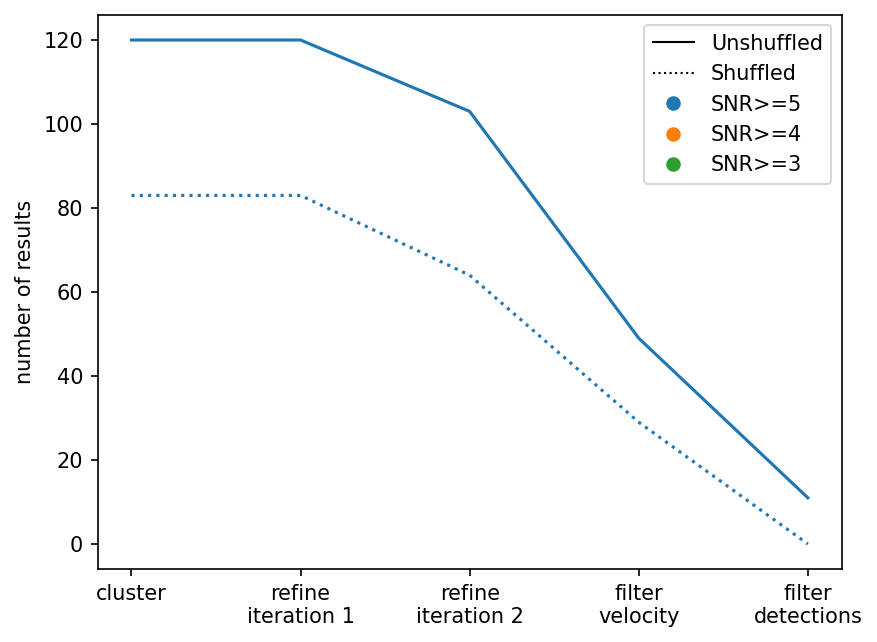

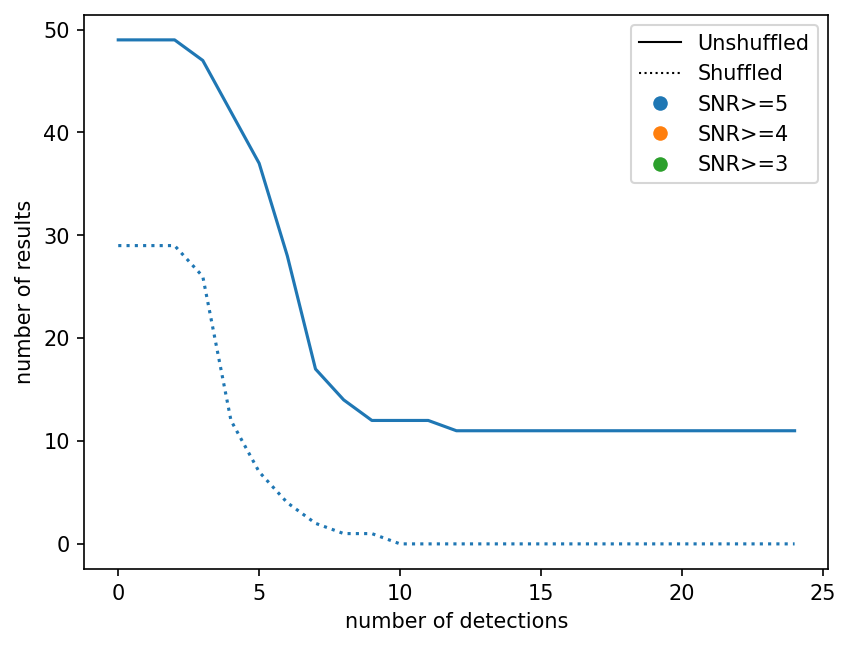

In [283]:
from matplotlib.lines import Line2D

snr_5 = number_of_results(4.0, 16)

fig = plt.figure(dpi=150)

plt.plot(snr_5['num_results']['x'], snr_5['num_results']['y'], color="C0", ls="-")
plt.plot(snr_5['num_results']['x'], snr_5['num_results']['y_s'], color="C0", ls=":")
# plt.plot(snr_4['num_results']['x'], snr_4['num_results']['y'], color="C1", ls="-")
# plt.plot(snr_4['num_results']['x'], snr_4['num_results']['y_s'], color="C1", ls=":")
# plt.plot(snr_3['num_results']['x'], snr_3['num_results']['y'], color="C2", ls="-")
# plt.plot(snr_3['num_results']['x'], snr_3['num_results']['y_s'], color="C2", ls=":")
plt.xticks(snr_5['num_results']['x'], ["cluster", "refine\niteration 1", "refine\niteration 2", "filter\nvelocity", "filter\ndetections"])
plt.ylabel("number of results")
custom_lines = [
    Line2D([0], [0], color="k", lw=1, ls="-", label="Unshuffled"),
    Line2D([0], [0], color="k", lw=1, ls=":", label="Shuffled"),
    Line2D([0], [0], marker="o", lw=0, color='w', markersize=8, markerfacecolor='C0', label="SNR>=5"),
    Line2D([0], [0], marker="o", lw=0, color='w', markersize=8, markerfacecolor='C1', label="SNR>=4"),
    Line2D([0], [0], marker="o", lw=0, color='w', markersize=8, markerfacecolor='C2', label="SNR>=3"),
]
plt.legend(handles=custom_lines)

plt.show()

fig = plt.figure(dpi=150)
# plt.scatter(snr_5['threshold']['t'], snr_5['threshold']['x'], color="C0", marker="o")
# plt.scatter(snr_5['threshold']['t'], snr_5['threshold']['y'], color="C0", marker="+")
# plt.scatter(snr_4['threshold']['t'], snr_4['threshold']['x'], color="C1", marker="o")
# plt.scatter(snr_4['threshold']['t'], snr_4['threshold']['y'], color="C1", marker="+")
plt.plot(snr_5['threshold']['t'], snr_5['threshold']['x'], color="C0", ls="-")
plt.plot(snr_5['threshold']['t'], snr_5['threshold']['y'], color="C0", ls=":")
# plt.plot(snr_4['threshold']['t'], snr_4['threshold']['x'], color="C1", ls="-")
# plt.plot(snr_4['threshold']['t'], snr_4['threshold']['y'], color="C1", ls=":")
# plt.plot(snr_3['threshold']['t'], snr_3['threshold']['x'], color="C2", ls="-")
# plt.plot(snr_3['threshold']['t'], snr_3['threshold']['y'], color="C2", ls=":")
# plt.xticks(snr_5['num_results']['x'], ["hough", "refine 1", "refine 2", "filter v", "filter n"])
plt.ylabel("number of results")
plt.xlabel("number of detections")
# plt.yscale("log")
custom_lines = [
    Line2D([0], [0], color="k", lw=1, ls="-", label="Unshuffled"),
    Line2D([0], [0], color="k", lw=1, ls=":", label="Shuffled"),
    Line2D([0], [0], marker="o", lw=0, color='w', markersize=8, markerfacecolor='C0', label="SNR>=5"),
    Line2D([0], [0], marker="o", lw=0, color='w', markersize=8, markerfacecolor='C1', label="SNR>=4"),
    Line2D([0], [0], marker="o", lw=0, color='w', markersize=8, markerfacecolor='C2', label="SNR>=3"),
]
plt.legend(handles=custom_lines)
plt.show()

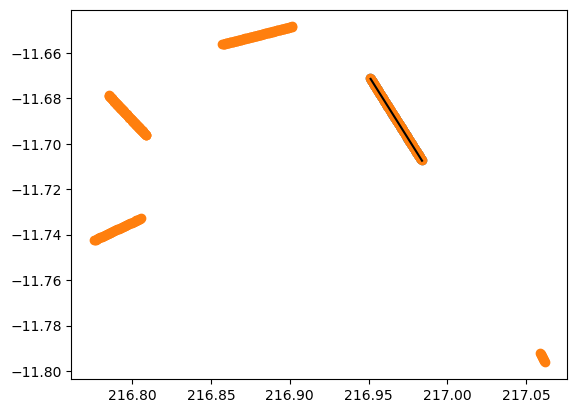

In [225]:
c_points = SkyCoord(c[1].points[:, 0]*u.deg, c[1].points[:, 1]*u.deg)
plt.scatter(c_points.ra, c_points.dec)
plt.plot(c_line.ra, c_line.dec, color='k')
plt.scatter(c_fake.ra, c_fake.dec)
plt.show()

In [181]:
fakes[(fakes['ORBITID'] == 10129264) & (fakes['CCDNUM'] == 23)]

RA,DEC,EXPNUM,CCDNUM,ORBITID,aei,mjd_mid,TDB,xv,H_VR,AMP,PERIOD,PHASE,d,observatory,r,MAG,type,night
float64,float64,int32,int64,int64,float64[6],float64,float64,float64[6],float64,float64,float64,float64,float64,float64[3],float64,float64,str8,int64
-143.01621725375628,-11.70722589079522,845872,23,10129264,2.738558126267186 .. 22.128640612292454,58577.21447994315,19.254525066949327,-2.8990547649732017 .. 1.071320689796274,18.13682336130603,0.0,0.0,0.0,3.3522339844335467,-0.9723130239773092 .. -0.09252563558321852,2.4118328591091664,22.675231022920627,asteroid,58576
-143.01653015601605,-11.70688169713224,845873,23,10129264,2.738558126267186 .. 22.128640612292454,58577.21619125002,19.25452975225221,-2.8990518553850304 .. 1.0713237645297382,18.13682336130603,0.0,0.0,0.0,3.3522365592335683,-0.9723063207295254 .. -0.09253705087391721,2.4118245490659445,22.675225208908074,asteroid,58576
-143.01685503180147,-11.70652435463787,845874,23,10129264,2.738558126267186 .. 22.128640612292454,58577.21796780527,19.254534616195542,-2.8990488347899164 .. 1.0713269564625247,18.13682336130603,0.0,0.0,0.0,3.3522392321847376,-0.9722993567140087 .. -0.09254890132897936,2.4118159273725954,22.675219177854217,asteroid,58576
-143.01716798357614,-11.706180147688034,845875,23,10129264,2.738558126267186 .. 22.128640612292454,58577.21967893464,19.2545393010123,-2.899045925367539 .. 1.071330030812239,18.13682336130603,0.0,0.0,0.0,3.3522418066783155,-0.9722926441883359 .. -0.09256031528333111,2.411807628215018,22.67521337338892,asteroid,58576
-143.01748154714673,-11.70583528614582,845876,23,10129264,2.738558126267186 .. 22.128640612292454,58577.22139319794,19.25454399440946,-2.899043010549507 .. 1.0713331107608854,18.13682336130603,0.0,0.0,0.0,3.3522443858678357,-0.9722859144864211 .. -0.09257175006685092,2.411799318807647,22.675207562710067,asteroid,58576
-143.017795459865,-11.705490057788554,845877,23,10129264,2.738558126267186 .. 22.128640612292454,58577.2231091633,19.254548692466642,-2.8990400927702713 .. 1.0713361937356596,18.13682336130603,0.0,0.0,0.0,3.3522469675988273,-0.9722791732233937 .. -0.09258319613091369,2.411791006120271,22.67520175069726,asteroid,58576
-143.01810940145586,-11.705144813586413,845878,23,10129264,2.738558126267186 .. 22.128640612292454,58577.22482508671,19.254553390408773,-2.899037174995348 .. 1.0713392766029994,18.13682336130603,0.0,0.0,0.0,3.3522495492472086,-0.9722724272637077 .. -0.09259464183675381,2.4117826986251742,22.675195943278773,asteroid,58576
-143.01842476411647,-11.704798021320528,845879,23,10129264,2.738558126267186 .. 22.128640612292454,58577.226548581515,19.254558109080563,-2.8990342442781643 .. 1.0713423730413378,18.13682336130603,0.0,0.0,0.0,3.3522521422675924,-0.972265646659101 .. -0.09260613797159109,2.411774359501984,22.675190114722856,asteroid,58576
-143.018737070397,-11.704454603547022,845880,23,10129264,2.738558126267186 .. 22.128640612292454,58577.228255184666,19.25456278150523,-2.899031342217839 .. 1.0713454391001194,18.13682336130603,0.0,0.0,0.0,3.3522547098548308,-0.9722589277096986 .. -0.09261752136145085,2.4117661070837624,22.6751843477312,asteroid,58576


In [244]:
data[(data['orbit'] == 14969959) & (data['snr'] == 5.0) & (data['type'] == 'unshuffled')]

type,snr,detector,target,night,orbit,found,findable,step,mag
str10,float64,int64,str3,int64,int64,bool,object,str23,float64
unshuffled,5.0,4,A0c,20190403,14969959,True,True,1,20.079699458973604
unshuffled,5.0,4,A0c,20190403,14969959,False,True,clusters,20.079699458973604
unshuffled,5.0,4,A0c,20190403,14969959,False,True,filter_removed_points,20.079699458973604
unshuffled,5.0,4,A0c,20190403,14969959,False,True,filter_removed_velocity,20.079699458973604
unshuffled,5.0,4,A0c,20190403,14969959,True,True,filter,20.079699458973604
unshuffled,5.0,4,A0c,20190403,14969959,False,True,2_removed,20.079699458973604
unshuffled,5.0,4,A0c,20190403,14969959,True,True,2,20.079699458973604
unshuffled,5.0,4,A0c,20190403,14969959,False,True,1_removed,20.079699458973604


In [157]:
fakes[fakes['ORBITID'] == 14969959]

RA,DEC,EXPNUM,CCDNUM,ORBITID,aei,mjd_mid,TDB,xv,H_VR,AMP,PERIOD,PHASE,d,observatory,r,MAG,type,night
float64,float64,int32,int64,int64,float64[6],float64,float64,float64[6],float64,float64,float64,float64,float64,float64[3],float64,float64,str8,int64
-143.8576560269507,-11.328527858790425,845577,9,14969959,2.4170424438391906 .. 19.87497893214308,58576.20992296842,19.25177473984536,-2.246225254302226 .. -0.777813975325686,17.810275630139095,0.045105524509657165,643.0896658862191,5.835982969327728,2.2693798462756987,-0.9760273212610613 .. -0.08581099176817941,1.2774456740539482,20.15530524973809,asteroid,58575
-143.85792612067033,-11.328288763203751,845578,9,14969959,2.4170424438391906 .. 19.87497893214308,58576.2116594204,19.251779493991762,-2.246219574167206 .. -0.7778105301733619,17.810275630139095,0.045105524509657165,643.0896658862191,5.835982969327728,2.2693766310780146,-0.9760210420431742 .. -0.08582262204343621,1.2774451966603493,20.15520982465892,asteroid,58575
-143.85819513028565,-11.328050652430457,845579,9,14969959,2.4170424438391906 .. 19.87497893214308,58576.213388463875,19.25178422785484,-2.2462139180955774 .. -0.777807099645975,17.810275630139095,0.045105524509657165,643.0896658862191,5.835982969327728,2.2693734296038124,-0.9760147845346665 .. -0.08583420263019371,1.2774447263374131,20.155114502364295,asteroid,58575
-143.8870159142487,-11.302377344004428,845686,4,14969959,2.4170424438391906 .. 19.87497893214308,58576.39832049783,19.252290544169682,-2.2456079828277407 .. -0.7774397590105165,17.810275630139095,0.045105524509657165,643.0896658862191,5.835982969327728,2.269031046530205,-0.9753215721257056 .. -0.08707240111584198,1.2774183940552297,20.14335013370929,asteroid,58575
-143.88728267365653,-11.3021355968623,845687,4,14969959,2.4170424438391906 .. 19.87497893214308,58576.40004913764,19.252295276927498,-2.2456023096996343 .. -0.7774363213524407,17.810275630139095,0.045105524509657165,643.0896658862191,5.835982969327728,2.269027846451788,-0.975314938258508 .. -0.08708397103675243,1.2774183046740002,20.143227324089704,asteroid,58575
-143.88754897108214,-11.301894151436208,845688,4,14969959,2.4170424438391906 .. 19.87497893214308,58576.40177542955,19.252300003257233,-2.245596644106973 .. -0.7774328882901078,17.810275630139095,0.045105524509657165,643.0896658862191,5.835982969327728,2.269024650725757,-0.9753083121090205 .. -0.08709552516813118,1.2774182167835417,20.143104479416714,asteroid,58575
-144.0089088606136,-11.188498902543955,845872,4,14969959,2.4170424438391906 .. 19.87497893214308,58577.21447994315,19.254525066949327,-2.2429105385736428 .. -0.7758085276715054,17.810275630139095,0.045105524509657165,643.0896658862191,5.835982969327728,2.267520836576216,-0.9723130239773092 .. -0.09252563558321852,1.2772475998972714,20.08346033742506,asteroid,58576
-144.00918448790665,-11.18825915204068,845873,4,14969959,2.4170424438391906 .. 19.87497893214308,58577.21619125002,19.25452975225221,-2.242904842744708 .. -0.775805090110555,17.810275630139095,0.045105524509657165,643.0896658862191,5.835982969327728,2.2675176714272616,-0.9723063207295254 .. -0.09253705087391721,1.277247605786744,20.08337538762768,asteroid,58576
-144.0094706874121,-11.188010223819877,845874,4,14969959,2.4170424438391906 .. 19.87497893214308,58577.21796780527,19.254534616195542,-2.242898929569548 .. -0.7758015214065364,17.810275630139095,0.045105524509657165,643.0896658862191,5.835982969327728,2.2675143856044073,-0.9722993567140087 .. -0.09254890132897936,1.2772476170433167,20.08328755367131,asteroid,58576


In [171]:
g1

type,snr,detector,target,night,orbit,found,findable,step,mag
str10,float64,int64,str3,int64,int64,bool,object,str23,float64
unshuffled,5.0,59,A0c,20190403,10002376,False,True,filter_removed_points,24.054322260817777
unshuffled,5.0,59,A0c,20190403,10002376,False,True,filter_removed_velocity,24.054322260817777
unshuffled,5.0,59,A0c,20190403,10002376,False,True,filter,24.054322260817777
unshuffled,5.0,59,A0c,20190403,10002376,False,True,2_removed,24.054322260817777
unshuffled,5.0,59,A0c,20190403,10002376,False,True,1_removed,24.054322260817777
unshuffled,5.0,59,A0c,20190403,10002376,False,True,1,24.054322260817777
unshuffled,5.0,59,A0c,20190403,10002376,False,True,clusters,24.054322260817777
unshuffled,5.0,59,A0c,20190403,10002376,False,True,2,24.054322260817777
unshuffled,5.0,1,A0c,20190403,10041343,False,None,filter_removed_points,22.428969812125573


In [165]:
bin_detection(g2, 18, 26)

([18.25,
  18.75,
  19.75,
  20.25,
  20.75,
  21.25,
  21.75,
  22.25,
  22.75,
  23.25,
  23.75,
  24.25,
  24.75,
  25.25,
  25.75,
  26.25],
 [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.1,
  0.0625,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.1,
  0.0625,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0])

In [152]:
fit_results

snr,target,night,step,m_50,sigma_m_50
float64,str3,int64,str8,float64,float64
3.0,A0c,20190403,1,24.965656917387037,0.2524350395515501
3.0,A0c,20190403,2,24.918843686525527,0.2309451445097159
3.0,A0c,20190403,clusters,24.583665229236583,nan
3.0,A0c,20190403,filter,24.710185259260474,0.11617645831745924
3.5,A0c,20190403,1,24.405168030487744,0.08161116223179103
3.5,A0c,20190403,2,24.401052297774427,0.08045523585639762
3.5,A0c,20190403,clusters,24.338010934816253,nan
3.5,A0c,20190403,filter,24.376059996844248,0.07793230042791467
4.0,A0c,20190403,1,24.190863578535087,0.07798333330811187


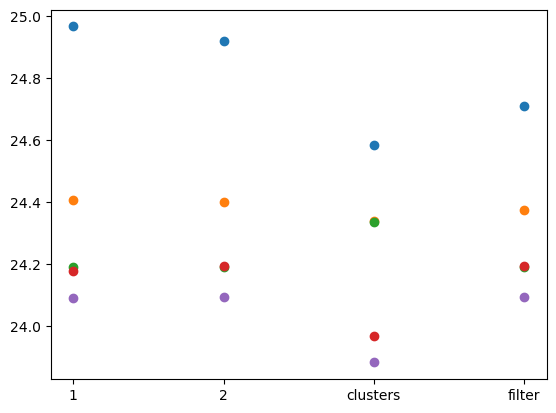

In [153]:
for g in fit_results.group_by(["snr"]).groups:
    plt.scatter(g['step'], g['m_50'])
plt.show()

In [30]:
unshuffled = list(
    map(
        read, 
        filter(
            lambda x : "unshuffled" in x,
            map(
                str, 
                Path("../search/single_search/DEEP/20190403/A0c").rglob("recovered_filter.pkl")
            )
        )
    )
)

In [32]:
list(map(was_found, unshuffled))

[{13039521: False,
  10564514: False,
  14621325: True,
  10053463: False,
  13776855: True,
  14813564: False,
  10041343: False},
 {13039521: False,
  10564514: False,
  14621325: True,
  10053463: False,
  13776855: True,
  14813564: False,
  10041343: False},
 {13039521: False,
  10564514: False,
  14621325: True,
  10053463: False,
  13776855: True,
  14813564: False,
  10041343: False},
 {13039521: False,
  10564514: False,
  14621325: True,
  10053463: False,
  13776855: True,
  14813564: True,
  10041343: False},
 {13039521: False,
  10564514: False,
  14621325: True,
  10053463: False,
  13776855: True,
  14813564: True,
  10041343: False},
 {11697512: False,
  13232368: False,
  10464147: False,
  11858549: False,
  13596119: False,
  12548062: True},
 {11697512: False,
  13232368: False,
  10464147: False,
  11858549: False,
  13596119: False,
  12548062: True},
 {11697512: False,
  13232368: False,
  10464147: False,
  11858549: False,
  13596119: False,
  12548062: True},
